# Optimizing Rate of Penetration in Geothermal Drilling: A Digital Twin Approach

Let’s explore something interesting together. In this project, we developed a machine learning digital twin using Intel-optimized XGBoost and daal4py to simulate and optimize the Rate of Penetration (ROP) in geothermal drilling. We leveraged SHAP for Explainable AI (XAI) to interpret model predictions, providing insights into the impact of input features. 

I would like to thank [Digital Twin Design for Renewable Energy Exploration](https://medium.com/intel-analytics-software/digital-twin-design-for-renewable-energy-exploration-2fcc4c545f8d) for providing the foundational concepts and methodologies used in this project.

#### **Digital Twin Design for Renewable Energy Exploration. Building Digital Twins with XGBoost.** 

## Introduction

Digital twins are virtual representations of physical objects or systems. These representations allow us to monitor the digital twin when exposed to external/internal variables and predict how it will perform in a production environment.

### Geothermal Energy Exploration

Geothermal energy exploration involves identifying and utilizing the Earth’s natural heat as a sustainable energy resource. Geoscientists focus on locating geothermal systems that have sufficient heat to justify the investment in drilling wells and constructing power plants. These systems can be categorized into:

- **In-field systems:** Located within known geothermal areas.
- **Near-field systems:** Adjacent to known geothermal areas.
- **Deep geothermal systems:** Found at greater depths, often requiring more advanced drilling techniques.

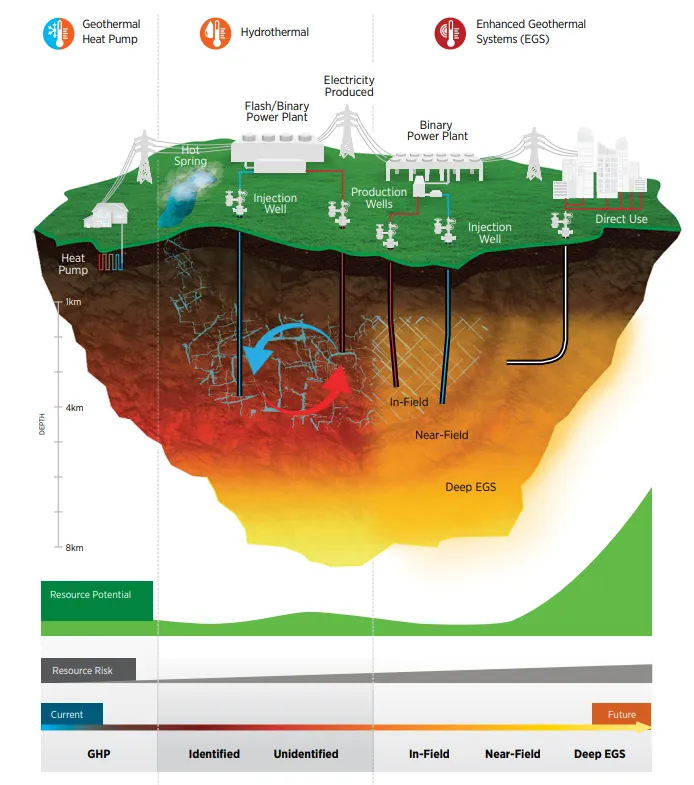

### Drilling Challenges

Drilling for geothermal energy, especially in high-pressure and high-temperature environments, presents several challenges:

- **Specialized Tools:** The extreme conditions require tools that can withstand high temperatures and pressures. This includes drill bits, casing, and drilling fluids designed to operate effectively under these conditions.
- **Temperature Requirements:** For flash and dry steam geothermal power plants, temperatures of at least 350°F (about 177°C) are needed. Such temperatures are typically found at depths greater than 10,000 feet (approximately 3,048 meters).
- **Sensor Durability:** High temperatures and pressures can damage sensors, making it difficult to monitor drilling conditions accurately.

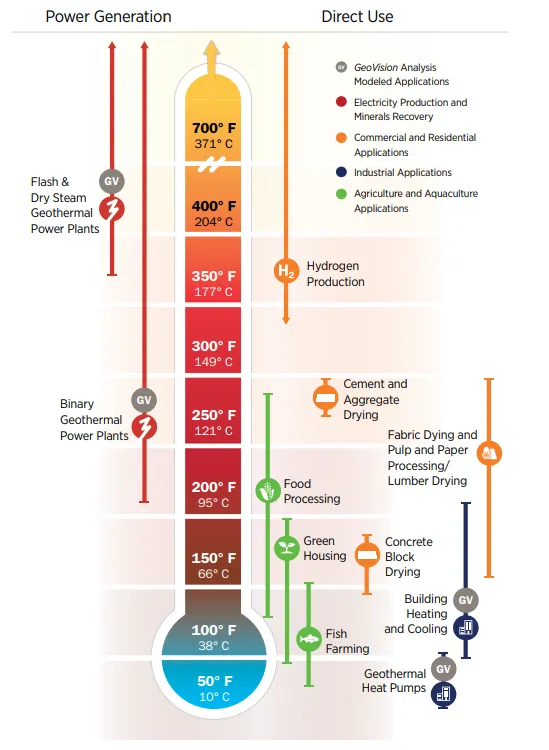

### Control Parameters

To optimize drilling conditions and ensure efficient and safe operations, several control parameters are monitored and adjusted:

- **Weight on Bit (WOB):** This is the downward force exerted on the drill bit. Proper WOB ensures effective penetration of the rock without damaging the bit.
- **Rotations Per Minute (RPM):** This measures the number of complete rotations made by the drill bit per minute. Adjusting RPM helps in managing the rate of penetration and the wear on the drill bit.
- **Flow Rate (FLOW):** This is the volume of liquid or slurry that moves through the drilling pipe per unit of time. Proper flow rate is crucial for cooling the drill bit, removing cuttings from the wellbore, and maintaining well pressure.
- **Torque (TOR):** This is the rotational force applied between the drill string and the rock. Managing torque is essential to prevent sticking of the drill string and to ensure smooth drilling operations.

### Building an AI Digital Twin Model

The goal of creating an AI digital twin model is to simulate the performance of geothermal wells. This involves:

- **Identifying Inputs and Outputs:** Understanding the physical system by identifying key inputs (e.g., WOB, RPM, FLOW, TOR) and outputs (e.g., rate of penetration, temperature, pressure).
- **Data Collection:** Gathering data from sensors and historical drilling operations to train the AI model.
- **Modeling and Simulation:** Using AI techniques to create a digital representation of the well, which can predict performance under various conditions and optimize drilling parameters.

## Digital Twin Concept

A **digital twin** is a virtual representation of a physical system or process. It uses real-time data and simulations to mirror the behavior and performance of its real-world counterpart. In the context of geothermal energy exploration, a digital twin can be used to model and optimize the performance of geothermal wells.

### How Digital Twins Work

1. **Data Collection**: Sensors and monitoring equipment collect data from the physical system. For geothermal wells, this includes data on WOB, RPM, FLOW, TOR, temperature, pressure, and other relevant parameters.
2. **Modeling**: This data is used to create a digital model of the well. The model incorporates the physical characteristics of the well and the surrounding geological formations.
3. **Simulation**: The digital twin can simulate various scenarios, such as changes in drilling parameters or unexpected conditions. This helps in predicting the performance of the well under different circumstances.
4. **Real-Time Monitoring**: The digital twin continuously updates with real-time data from the physical well. This allows for ongoing monitoring and optimization of drilling operations.
5. **Optimization**: By analyzing the data and simulations, the digital twin can suggest adjustments to drilling parameters to improve efficiency, reduce costs, and enhance safety.

### Benefits of Digital Twins in Geothermal Drilling

- **Predictive Maintenance**: By monitoring the condition of drilling equipment and predicting potential failures, digital twins can help in scheduling maintenance before issues arise.
- **Performance Optimization**: Digital twins can identify the optimal settings for WOB, RPM, FLOW, and TOR to maximize drilling efficiency and minimize wear on equipment.
- **Risk Management**: Simulating different scenarios helps in understanding potential risks and developing strategies to mitigate them.
- **Cost Reduction**: By optimizing drilling operations and reducing downtime, digital twins can significantly lower the overall cost of geothermal energy exploration.

### Application in Geothermal Energy

In geothermal energy exploration, digital twins are particularly valuable because they allow for:

- **Enhanced Decision-Making**: Providing a comprehensive view of the well's performance and potential issues.
- **Improved Safety**: Monitoring high-pressure, high-temperature environments in real-time to prevent accidents.
- **Sustainability**: Ensuring that geothermal wells are drilled and operated in the most efficient and environmentally friendly manner.

By leveraging digital twin technology, geoscientists and engineers can better understand and manage the complexities of geothermal drilling, leading to more successful and cost-effective energy production.

## Libraries and Utility Functions

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import sys
import joblib
import shap
import numpy as np
import xgboost as xgb
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

#### **Utilities to handle various aspects of XGBoost and Daal4Py modeling and optimizations.**

- **prepare_data**: Splits the dataset into training and testing sets.
- **linreg**: Trains and evaluates a linear regression model, optionally using Intel's optimizations.
- **XGBHyper_train**: Trains an XGBoost model with hyperparameter tuning.
- **XGBReg_train**: Trains an XGBoost model with specified parameters.
- **XGB_predict**: Makes predictions using a trained XGBoost model and calculates the mean squared error.
- **XGB_predict_daal4py**: Makes predictions using a trained XGBoost model with daal4py optimizations.
- **XGB_predict_aug**: Makes predictions using a trained XGBoost model with optional daal4py optimizations.
- **data_proc**: Processes raw data by applying a rolling mean and optional interpolation, and plots the processed data.

In [2]:
def prepare_data(df0, input_cols_list, output_var, test_size=0.3, shuffle=True):
    """
    Prepares the data for training and testing by splitting the dataset.

    Parameters:
    df0 (DataFrame): The original dataframe.
    input_cols_list (list): List of column names to be used as input features.
    output_var (str): The name of the output variable/target column.
    test_size (float): The proportion of the dataset to include in the test split.
    shuffle (bool): Whether or not to shuffle the data before splitting.

    Returns:
    tuple: Contains the training and testing data for both input features and target variable.
    """
    df1 = df0.copy()
    x_data = df1[input_cols_list]
    y_data = df1[str(output_var)]
    x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(
        x_data, y_data, test_size=test_size, random_state=42)
    return (x_train_df, x_test_df, y_train_df, y_test_df)

"""
Functions for training/inferencing ML models
"""

def linreg(x_train, x_test, y_train, y_test, i_flag):
    """
    Trains and evaluates a linear regression model.

    Parameters:
    x_train (DataFrame): Training data for input features.
    x_test (DataFrame): Testing data for input features.
    y_train (Series): Training data for target variable.
    y_test (Series): Testing data for target variable.
    i_flag (bool): Flag to indicate if Intel's sklearnex optimizations should be used.

    Returns:
    tuple: Minimum training time, minimum prediction time, and mean squared error (MSE).
    """
    if i_flag:
        from sklearnex import patch_sklearn  # Apply Intel optimizations
        patch_sklearn()
    
    regr = linear_model.LinearRegression()
    train_time = []
    pred_time = []
    for _ in range(10):
        # Training start
        regr_train_start = time.time()
        regr.fit(x_train, y_train)
        regr_train_time = time.time() - regr_train_start
        train_time.append(regr_train_time)
        
        # Prediction start
        regr_pred_start = time.time()
        y_pred = regr.predict(x_test)
        regr_pred_time = time.time() - regr_pred_start
        pred_time.append(regr_pred_time)
    
    MSE = np.square(np.subtract(y_test, y_pred)).mean()
    return min(train_time), min(pred_time), MSE
    
def XGBHyper_train(x_train, y_train, params):
    """
    Trains an XGBoost model using hyperparameter tuning with GridSearchCV.

    Parameters:
    x_train (DataFrame): Training data for input features.
    y_train (Series): Training data for target variable.
    params (dict): Dictionary of hyperparameters to be tuned.

    Returns:
    tuple: Training time, best estimator, and best hyperparameters.
    """
    xgb_trainer = xgb.XGBRegressor()
    xgbh_grid = GridSearchCV(xgb_trainer, params, cv=4, n_jobs=8, verbose=True)
    xgbh_start = time.time()
    xgbh_grid.fit(x_train, y_train)
    xgbh_train = time.time() - xgbh_start
    best_params = xgbh_grid.best_params_
    best_grid = xgbh_grid.best_estimator_

    return xgbh_train, best_grid, best_params

def XGBReg_train(x_train, y_train, loop_ctr, i_flag, params=None):
    """
    Trains an XGBoost model with specified parameters.

    Parameters:
    x_train (DataFrame): Training data for input features.
    y_train (Series): Training data for target variable.
    loop_ctr (int): Number of training iterations.
    i_flag (bool): Flag to indicate if Intel's optimizations should be used.
    params (dict, optional): Dictionary of parameters for the XGBoost model.

    Returns:
    tuple: Minimum training time and trained XGBoost model.
    """
    if params is None:
        params = {'n_estimators': 500, 'tree_method': 'hist'}
    xgb_model = xgb.XGBRegressor(**params)
    train_time = []
    for _ in range(loop_ctr):
        # Training start
        xgb_train_start = time.time()
        xgb_model.fit(x_train, y_train)
        xgb_train_time = time.time() - xgb_train_start
        train_time.append(xgb_train_time)
    
    return min(train_time), xgb_model
    
def XGB_predict(x_test, y_test, xgb_model, loop_ctr, i_flag):
    """
    Predicts using a trained XGBoost model and calculates the mean squared error.

    Parameters:
    x_test (DataFrame): Testing data for input features.
    y_test (Series): Testing data for target variable.
    xgb_model (XGBRegressor): Trained XGBoost model.
    loop_ctr (int): Number of prediction iterations.
    i_flag (bool): Flag to indicate if Intel's optimizations should be used.

    Returns:
    tuple: Predictions, minimum prediction time, and mean squared error (MSE).
    """
    pred_time = []
    for _ in range(loop_ctr):
        # Prediction start
        xgb_pred_start = time.time()
        y_pred = xgb_model.predict(x_test)
        xgb_pred_time = time.time() - xgb_pred_start
        pred_time.append(xgb_pred_time)

    MSE = np.square(np.subtract(y_test, y_pred)).mean()
    return y_pred, min(pred_time), MSE

def XGB_predict_daal4py(x_test, y_test, xgb_model, loop_ctr, i_flag):
    """
    Predicts using a trained XGBoost model with daal4py optimizations and calculates the mean squared error.

    Parameters:
    x_test (DataFrame): Testing data for input features.
    y_test (Series): Testing data for target variable.
    xgb_model (XGBRegressor): Trained XGBoost model.
    loop_ctr (int): Number of prediction iterations.
    i_flag (bool): Flag to indicate if Intel's optimizations should be used.

    Returns:
    tuple: Predictions, minimum prediction time, and mean squared error (MSE).
    """
    pred_time = []
    import daal4py as d4p  # Intel optimizations
    daal_model = d4p.get_gbt_model_from_xgboost(xgb_model.get_booster())
    for _ in range(loop_ctr):
        # Prediction start
        xgb_pred_start = time.time()
        y_pred = d4p.gbt_regression_prediction().compute(x_test, daal_model).prediction.reshape(-1)
        xgb_pred_time = time.time() - xgb_pred_start
        pred_time.append(xgb_pred_time)
    MSE = np.square(np.subtract(y_test, y_pred)).mean()
    return y_pred, min(pred_time), MSE

def XGB_predict_aug(x_test, xgb_model, i_flag):
    """
    Predicts using a trained XGBoost model with optional daal4py optimizations.

    Parameters:
    x_test (DataFrame): Testing data for input features.
    xgb_model (XGBRegressor): Trained XGBoost model.
    i_flag (bool): Flag to indicate if Intel's optimizations should be used.

    Returns:
    array: Predictions.
    """
    if i_flag:
        import daal4py as d4p  # Intel optimizations
        daal_model = d4p.get_gbt_model_from_xgboost(xgb_model.get_booster())
    
    # Prediction start
    if i_flag:
        y_pred = d4p.gbt_regression_prediction().compute(x_test, daal_model).prediction.reshape(-1)
    else:
        y_pred = xgb_model.predict(x_test)
    return y_pred

def data_proc(raw_df, features, depth_var, dropna=False, rolling_win=10, interpolate=None):
    """
    Processes the raw data by applying rolling mean and optional interpolation.

    Parameters:
    raw_df (DataFrame): The raw input dataframe.
    features (list): List of feature column names to be processed.
    depth_var (str): The name of the depth variable column.
    dropna (bool): Whether to drop rows with NaN values.
    rolling_win (int): Window size for rolling mean.
    interpolate (str, optional): Method for interpolation.

    Returns:
    DataFrame: Processed data with rolling mean applied.
    """
    chosen_features = features
    
    processed_data = pd.DataFrame()
    colors = ['b', 'r', 'g', 'y', 'm', 'p', 'c', 'k'] * 10 
    for feature in chosen_features:
        processed_data[feature + '_P'] = raw_df[feature].rolling(rolling_win).mean()
        processed_data[depth_var] = raw_df[depth_var]
        
    if dropna:
        processed_data.dropna(inplace=True)
    
    if interpolate:
        processed_data.interpolate(interpolate)
        
    fig, axes = plt.subplots(1, len(features), figsize=(30, 15), sharey=True)
    
    processed_columns = list(processed_data.columns)
    processed_columns.remove(depth_var)

    for idx, feature in enumerate(processed_columns):
        axes[idx].plot(processed_data[feature], processed_data[depth_var], colors[idx])
        axes[idx].grid(True) 
        axes[idx].set_xlabel(feature)
        axes[idx].invert_yaxis()
        axes[idx].xaxis.set_label_position('top')
        axes[idx].xaxis.tick_top()
        if idx == 0:
            axes[idx].set_ylabel(depth_var)   
    
    return processed_data

## Exploratory Data Analysis

The **Utah FORGE** (Frontier Observatory for Research in Geothermal Energy) project is a significant initiative aimed at advancing geothermal energy technologies. It serves as a dedicated underground field laboratory where various technologies related to enhanced geothermal systems (EGS) are developed, tested, and accelerated.

### The Dataset
The dataset you mentioned is from the drilling of the **Utah FORGE 58–32 MU-ESW1 well** near Roosevelt Hot Springs. This dataset is collected using an **Electronic Drilling Recorder (EDR)**, which is a system that captures and records various drilling parameters in real-time.

### Key Parameters in the Dataset
The dataset is recorded at one-foot intervals and covers depths from **85.18 feet to 7536.25 feet**. Here are some of the key parameters included:

- **Depth**: The vertical distance from the surface to the point of measurement.
- **Rate of Penetration (ROP)**: The speed at which the drill bit advances through the rock, usually measured in feet per hour.
- **Weight on Bit (WOB)**: The amount of downward force applied to the drill bit.
- **Hookload**: The total weight suspended from the hook, including the drill string and any additional equipment.
- **Temperatures In and Out**: The temperature of the drilling fluid entering and exiting the wellbore.
- **Pump Pressure**: The pressure exerted by the pumps circulating the drilling fluid.
- **Flows In and Out**: The volume of drilling fluid being pumped into and out of the well.
- **H2S**: The concentration of hydrogen sulfide gas, which is a hazardous gas that can be encountered during drilling.

### Purpose of the Data
This data is crucial for several reasons:
1. **Monitoring and Control**: Real-time monitoring of these parameters helps in controlling the drilling process, ensuring safety, and optimizing performance.
2. **Training Models**: The data can be used to train machine learning models to predict and optimize drilling performance, detect anomalies, and improve overall efficiency.
3. **Research and Development**: It supports research into new drilling technologies and methods, contributing to the advancement of geothermal energy extraction.

### Application in Enhanced Geothermal Systems (EGS)
Enhanced Geothermal Systems involve creating artificial reservoirs in hot rock formations by injecting fluid to enhance permeability. The data from the EDR helps in understanding the subsurface conditions and optimizing the drilling process to create these reservoirs effectively.

In [3]:
geothermal_drilling_data_raw = pd.read_csv('/kaggle/input/geothermal-drilling-data-utah-forge-mu-esw1/MU-ESW1 data to 7536(TD).csv')
headers = geothermal_drilling_data_raw.iloc[1]
geothermal_drilling_data_raw = pd.DataFrame(geothermal_drilling_data_raw.values[2:], columns=headers)
geothermal_drilling_data_raw.columns.name=None
geothermal_drilling_data_raw = geothermal_drilling_data_raw.iloc[:, :17]
geothermal_drilling_data_raw = geothermal_drilling_data_raw.apply(pd.to_numeric, errors='coerce')
geothermal_drilling_data_raw.columns

Index(['Depth', 'ROP(1 ft)', 'WOB (k-lbs)', 'Temp Out( degF)', 'Temp In(degF)',
       'Pit Total (bbls)', 'Pump Press (psi)', 'ROP(1 min)',
       'Hookload (k-lbs)', 'Surface Torque (psi)', 'Rotary Speed (rpm)',
       'Flow In (gpm)', 'Flow Out %', 'WH Pressure (psi)', 'H2S Floor',
       'H2S Cellar', 'H2S Pits'],
      dtype='object')

In [4]:
geothermal_drilling_data_raw.describe()

,Depth,ROP(1 ft),WOB (k-lbs),Temp Out( degF),Temp In(degF),Pit Total (bbls),Pump Press (psi),ROP(1 min),Hookload (k-lbs),Surface Torque (psi),Rotary Speed (rpm),Flow In (gpm),Flow Out %,WH Pressure (psi),H2S Floor,H2S Cellar,H2S Pits
count,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000
mean,3835.043935,42.010324,23.116699,126.059506,118.315593,236.929204,1266.634496,35.341219,81.285593,130.983649,54.947292,716.254127,79.692834,-35.760875,-0.027372,0.004303,0.148833
std,2147.503980,75.921118,9.119495,12.259879,11.933137,18.261640,490.554609,42.557374,26.503832,48.706651,25.947654,141.784179,11.909399,222.669489,0.042453,0.025282,0.115290
min,85.180000,0.000000,0.000000,84.070000,85.000000,170.910000,19.940000,0.000000,27.270000,0.000000,0.000000,0.000000,0.690000,-1231.830000,-0.100000,-0.080000,-0.060000
25%,1970.395000,11.400000,18.310000,116.130000,108.850000,224.535000,665.590000,10.905000,54.720000,117.000000,38.090000,620.260000,72.650000,2.920000,-0.070000,-0.010000,0.060000
50%,3851.850000,17.990000,23.830000,124.860000,117.220000,238.110000,1432.560000,17.580000,80.140000,140.310000,50.380000,700.210000,80.710000,5.940000,-0.010000,0.000000,0.140000
75%,5691.585000,44.295000,29.680000,136.490000,126.860000,249.590000,1669.680000,41.635000,105.630000,157.280000,75.965000,824.610000,88.845000,8.260000,0.000000,0.020000,0.220000
max,7536.250000,2977.910000,47.050000,151.700000,146.310000,279.880000,2200.430000,500.840000,148.930000,273.710000,271.580000,3317.510000,111.210000,17.410000,0.780000,0.070000,0.720000


In [5]:
geothermal_drilling_data_raw.head(10)

,Depth,ROP(1 ft),WOB (k-lbs),Temp Out( degF),Temp In(degF),Pit Total (bbls),Pump Press (psi),ROP(1 min),Hookload (k-lbs),Surface Torque (psi),Rotary Speed (rpm),Flow In (gpm),Flow Out %,WH Pressure (psi),H2S Floor,H2S Cellar,H2S Pits
0,85.18,56.80,0.00,93.49,90.87,274.83,463.72,28.70,31.77,8.93,151.09,1109.58,101.61,-1230.69,-0.01,-0.03,0.31
1,86.18,61.14,0.00,93.52,90.83,274.83,459.53,70.44,31.01,8.93,151.09,1108.36,101.70,-1230.69,-0.01,-0.04,0.31
2,87.23,18.58,0.00,94.25,90.91,273.80,454.57,23.90,31.01,9.01,61.54,1102.87,96.81,-1230.69,-0.01,-0.03,0.30
3,88.26,38.29,0.00,94.44,91.14,273.79,451.14,35.66,31.16,8.97,60.23,1101.04,96.67,-1230.69,0.00,-0.03,0.31
4,89.36,394.38,0.00,94.48,91.18,273.80,456.09,69.95,31.54,8.97,61.75,1102.46,96.63,-1230.69,-0.02,-0.02,0.31
5,90.39,413.16,0.00,94.52,91.18,273.79,452.28,99.67,30.24,8.97,61.99,1101.85,96.58,-1230.69,-0.01,-0.02,0.31
6,91.39,450.72,0.76,94.52,91.21,273.80,454.19,127.04,29.33,8.97,62.07,1102.06,96.72,-1230.69,-0.01,-0.02,0.31
7,92.39,600.96,0.00,94.52,91.21,273.79,452.66,154.97,31.01,9.01,61.95,1102.26,96.81,-1230.69,-0.02,-0.03,0.31
8,93.49,399.50,0.00,94.55,91.25,273.80,448.85,178.32,30.93,8.97,61.42,1099.21,96.44,-1230.69,-0.01,-0.03,0.30
9,94.59,563.40,0.00,94.55,91.29,273.79,452.66,204.71,30.78,9.01,59.57,1102.87,95.93,-1230.69,-0.02,-0.03,0.30


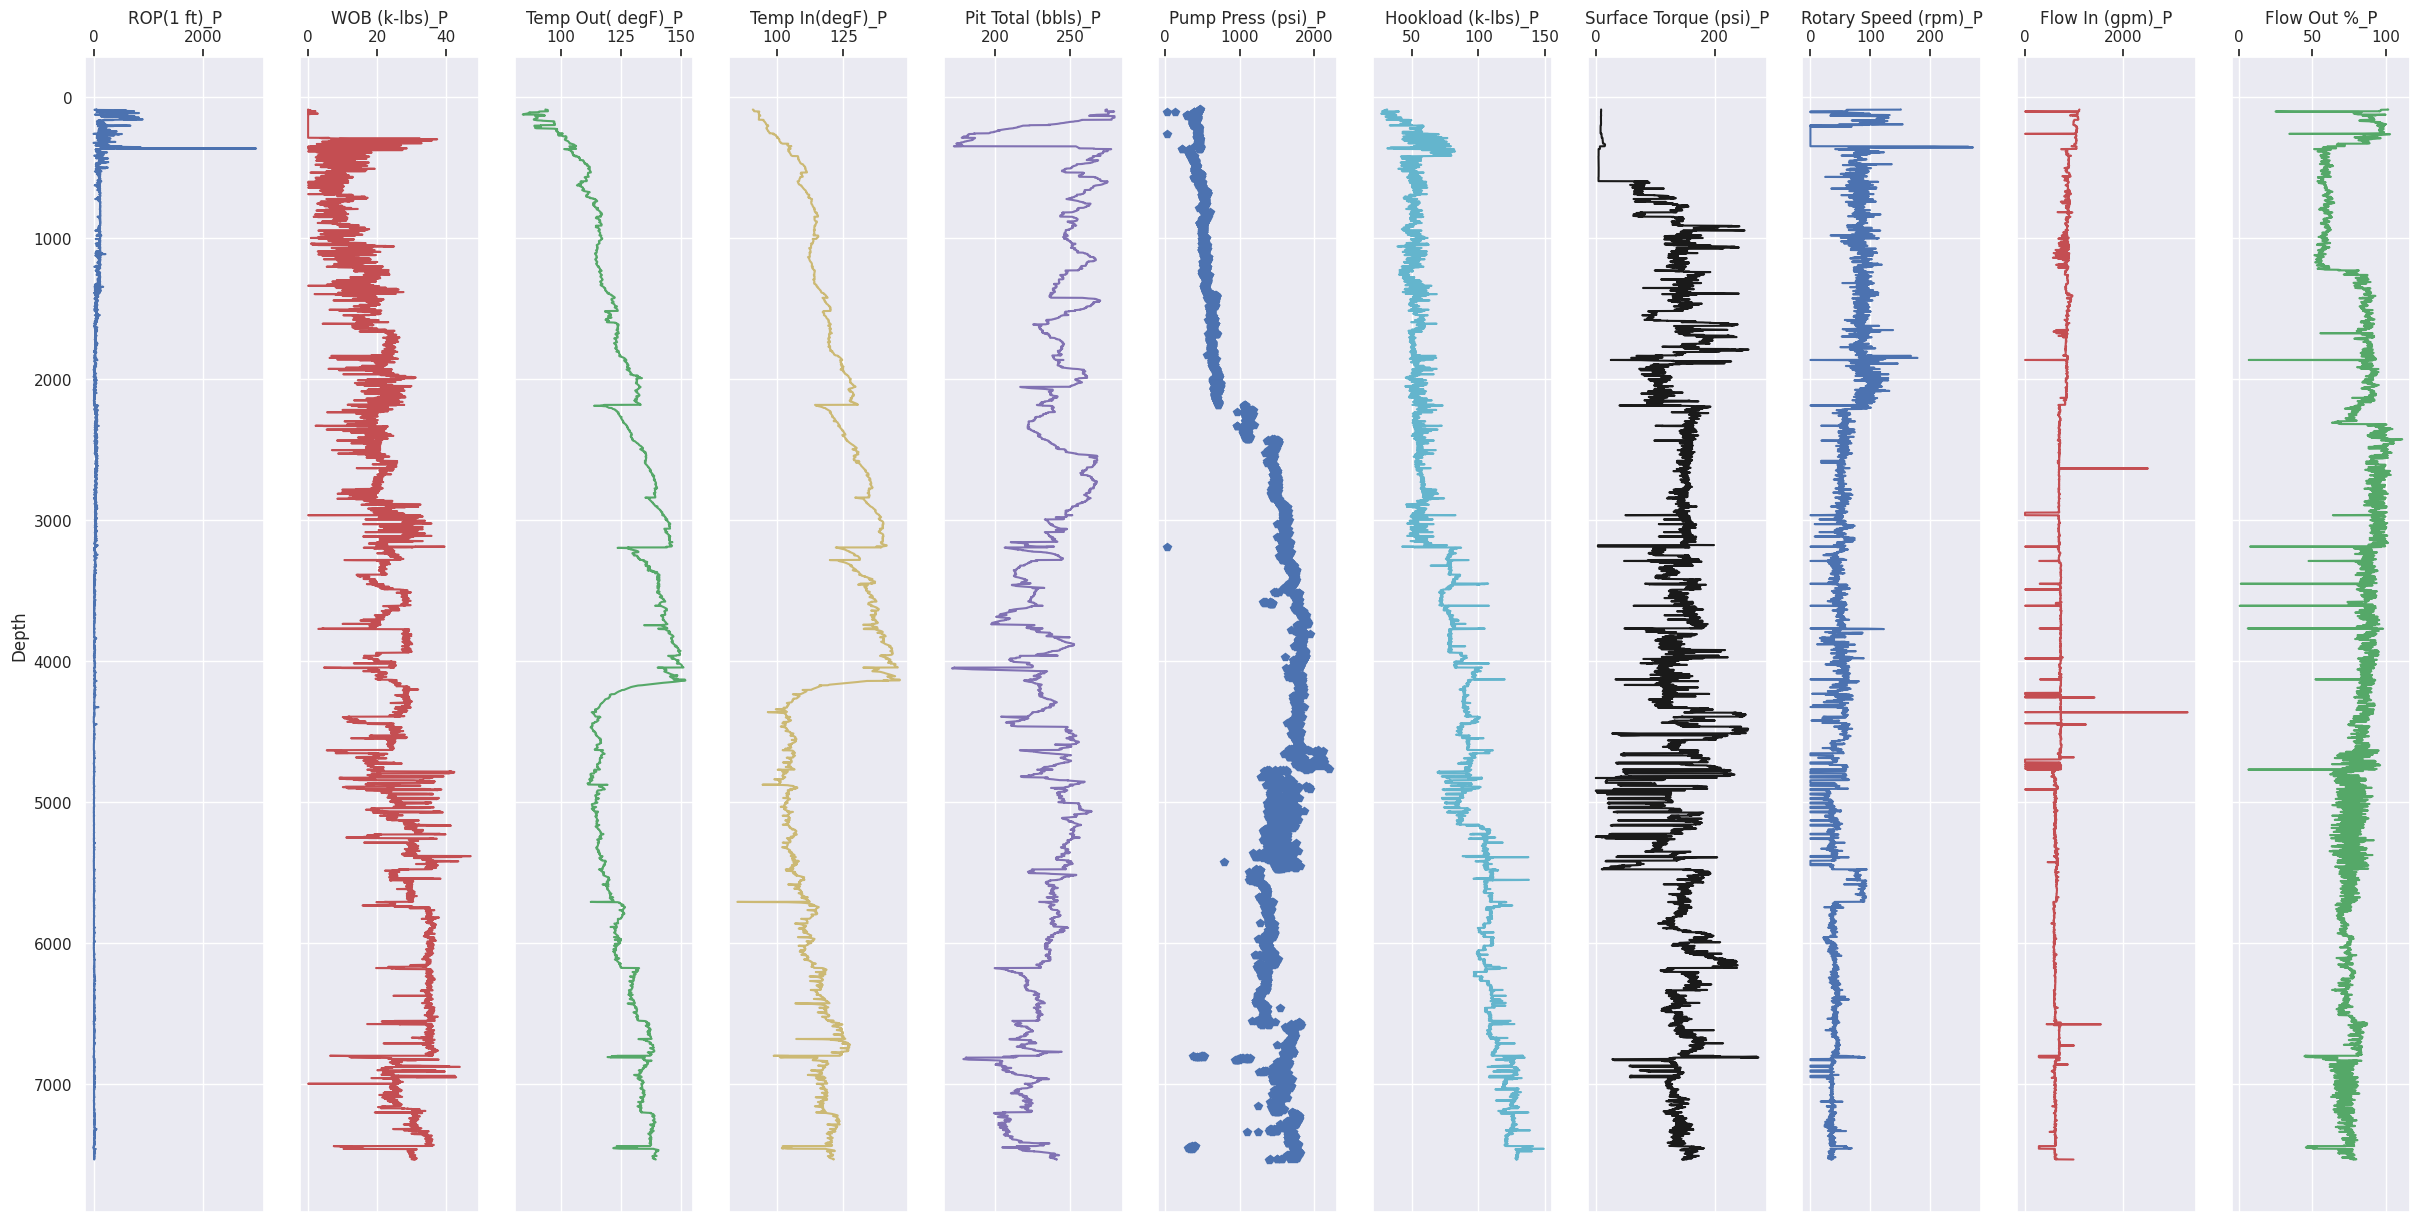

In [6]:
features = ['ROP(1 ft)', 'WOB (k-lbs)', 'Temp Out( degF)', 'Temp In(degF)','Pit Total (bbls)', 'Pump Press (psi)','Hookload (k-lbs)', 
                     'Surface Torque (psi)', 'Rotary Speed (rpm)','Flow In (gpm)', 'Flow Out %']

geothermal_data_prelim = data_proc(geothermal_drilling_data_raw, features, depth_var='Depth', dropna=False, rolling_win=1, interpolate=None)

### Data Pre-Processing 

For digital twins, we must first define the causal relationships within the modeled system. To achieve this, we will separate the inputs and outputs of the drill rig. This leaves WOB, TOR, RPM, and FLOW as inputs and ROP as our sole output. **ROP defines the amount of downward force applied to rock during drilling.** Lastly, we will remove the first 1000ft of data to focus on areas where drilling is slow and can be improved, like zones of high pressure and temperature.

In [7]:
geothermal_drilling_data_1000ft = geothermal_drilling_data_raw.loc[geothermal_drilling_data_raw['Depth'] > 1000, :]
geothermal_drilling_data_1000ft.head(10)

,Depth,ROP(1 ft),WOB (k-lbs),Temp Out( degF),Temp In(degF),Pit Total (bbls),Pump Press (psi),ROP(1 min),Hookload (k-lbs),Surface Torque (psi),Rotary Speed (rpm),Flow In (gpm),Flow Out %,WH Pressure (psi),H2S Floor,H2S Cellar,H2S Pits
875,1000.03,122.11,9.32,117.09,114.89,246.32,507.18,121.06,53.48,153.12,112.13,865.00,58.20,5.21,0.0,-0.01,0.25
876,1001.09,122.64,3.01,117.12,114.85,246.03,506.42,120.86,59.79,159.60,78.88,686.03,56.59,5.59,0.0,0.00,0.25
877,1002.13,120.42,4.95,117.12,114.81,246.03,504.89,121.26,57.85,126.59,80.55,856.19,57.41,5.21,0.0,0.00,0.25
878,1003.16,120.40,9.40,117.12,114.78,246.03,503.37,121.06,53.40,133.95,87.08,682.13,57.99,5.21,0.0,0.00,0.26
879,1004.18,41.17,8.00,116.82,113.40,248.43,501.08,7.63,54.80,117.74,75.98,853.16,59.22,4.45,0.0,-0.01,0.26
880,1005.22,103.71,13.11,116.86,113.44,248.46,507.56,37.07,49.69,126.28,62.80,850.43,59.78,4.45,0.0,0.00,0.26
881,1006.24,104.66,6.85,116.86,113.52,248.16,499.94,57.93,55.95,115.07,79.52,848.62,58.11,4.45,0.0,-0.01,0.26
882,1007.26,104.70,13.28,116.74,113.52,248.14,509.47,71.89,49.52,134.44,68.59,860.92,59.93,4.45,0.0,0.00,0.26
883,1008.29,120.42,10.72,116.70,113.56,248.44,509.85,85.31,52.08,133.64,75.61,863.79,60.01,4.45,0.0,0.01,0.27
884,1009.33,106.66,10.27,116.63,113.59,248.11,506.42,92.38,52.53,139.17,81.74,863.58,60.83,4.83,0.0,0.00,0.26


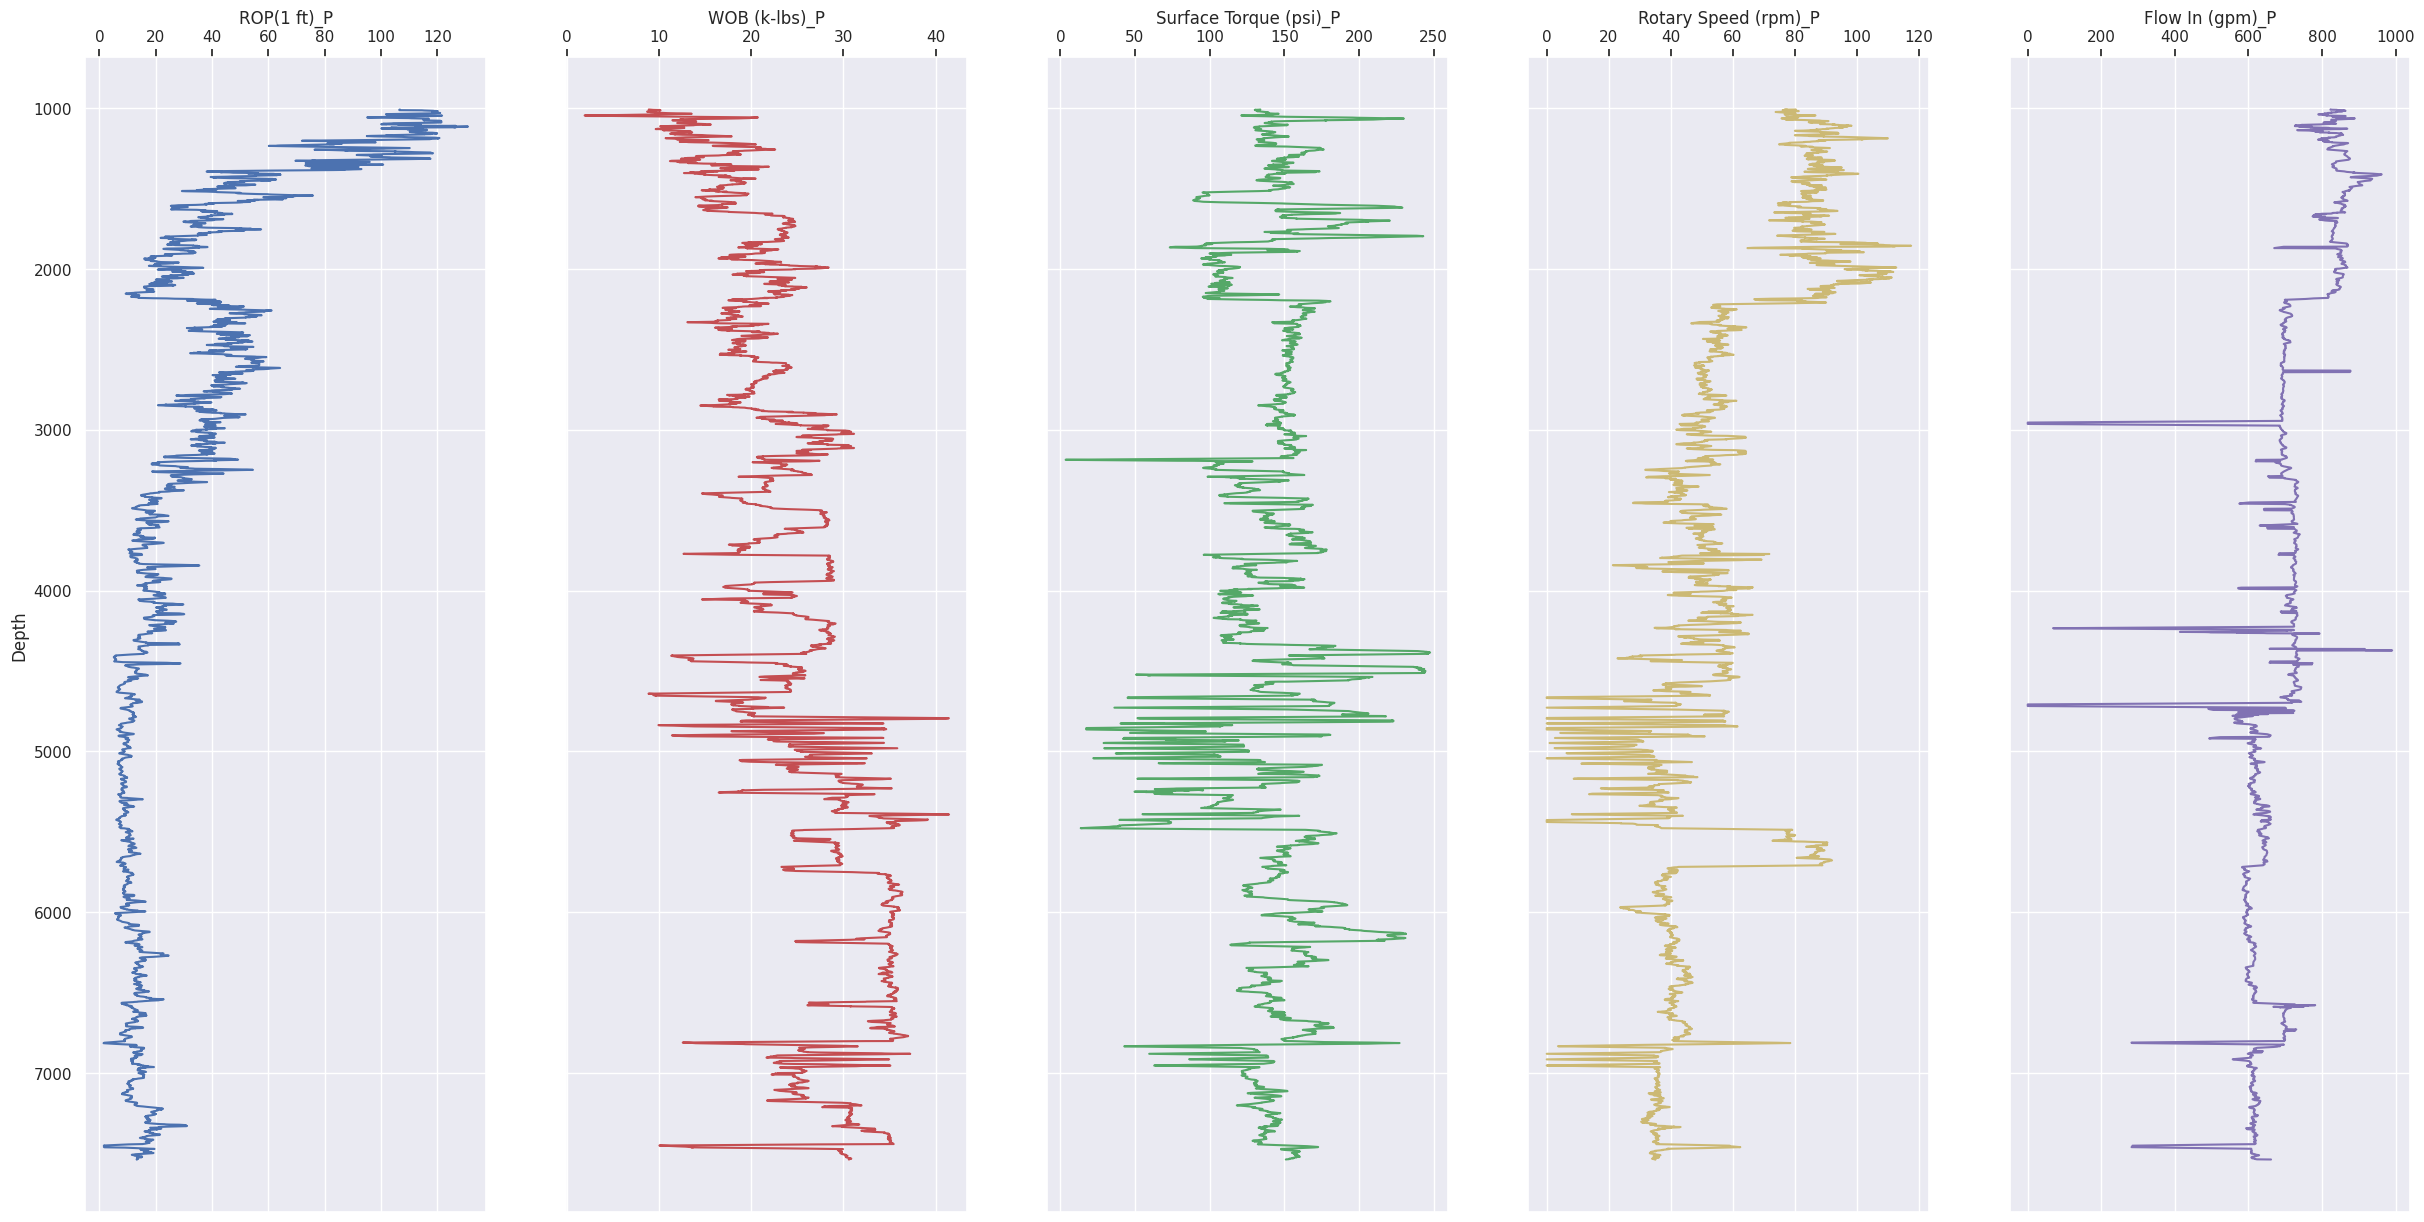

In [8]:
final_features = ['ROP(1 ft)', 'WOB (k-lbs)', 'Surface Torque (psi)', 'Rotary Speed (rpm)','Flow In (gpm)']
geothermal_data_final = data_proc(geothermal_drilling_data_1000ft, final_features, depth_var='Depth', dropna=True, rolling_win=10, interpolate='cubic')

### Feature Analysis 

**Pearson correlation matrix** to analyze the relationships between our features 

- **Positive Relation:** Flow in, rotary speed, and ROP show moderate positive correlations. This makes sense because fluid flow through the drill string helps spin the bit, leading to higher rotation speeds and rates of penetration. 
- **Negative Relation:** Between ROP and Depth. As depth increases, the rate of penetration (ROP) decreases due to harder rock formations, higher pressure and temperature, and equipment wear.
- **Positive Relation:** Between WOB and Depth. As depth increases, the weight on bit (WOB) increases to counteract the reduced ROP and overcome greater resistance from deeper formations.

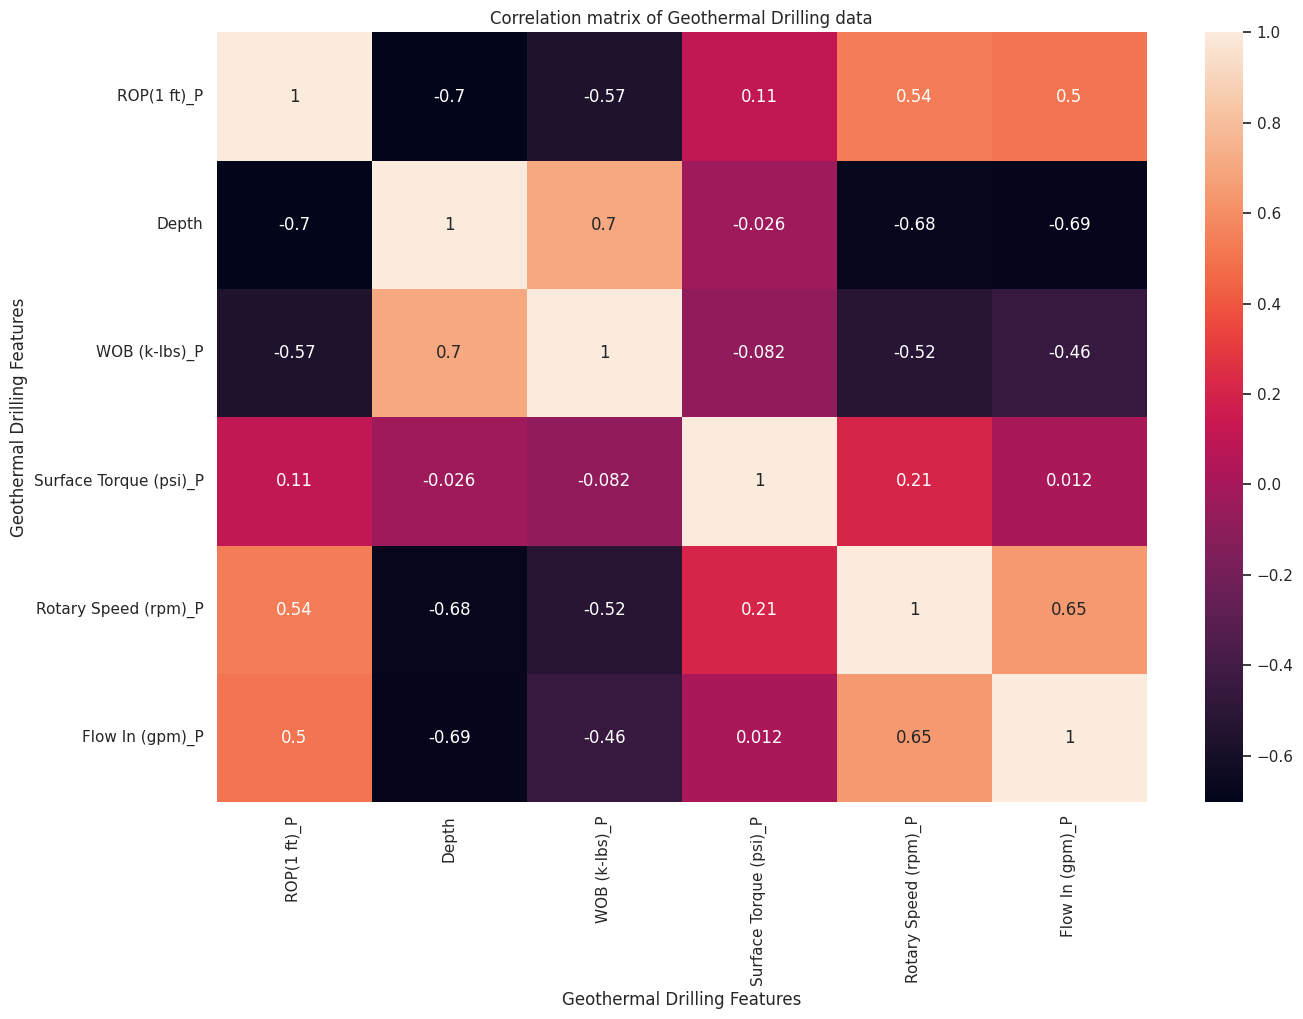

In [9]:
correlation_mat = geothermal_data_final.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlation_mat, annot = True)
plt.title("Correlation matrix of Geothermal Drilling data")
plt.xlabel("Geothermal Drilling Features")
plt.ylabel("Geothermal Drilling Features")
plt.show()

**Pairplot Analysis**

Next, we will perform a pair plot analysis, which uses a “small multiple” approach to visualize the univariate distribution of all variables in a dataset along with all of their pairwise relationships. From the diagonal histograms, we see various complex multi-modal and skewed distributions. The kernel density maps associated with depth indicate a complex distribution of clusters for each control parameter, representing multiple rock types and the parameters used to drill through them. 

A pair plot analysis is particularly useful for visualizing these relationships, as it reveals complex, multi-modal, and skewed distributions through diagonal histograms. The kernel density maps for depth highlight clusters for each control parameter, indicating the presence of various rock types and the drilling parameters employed. 

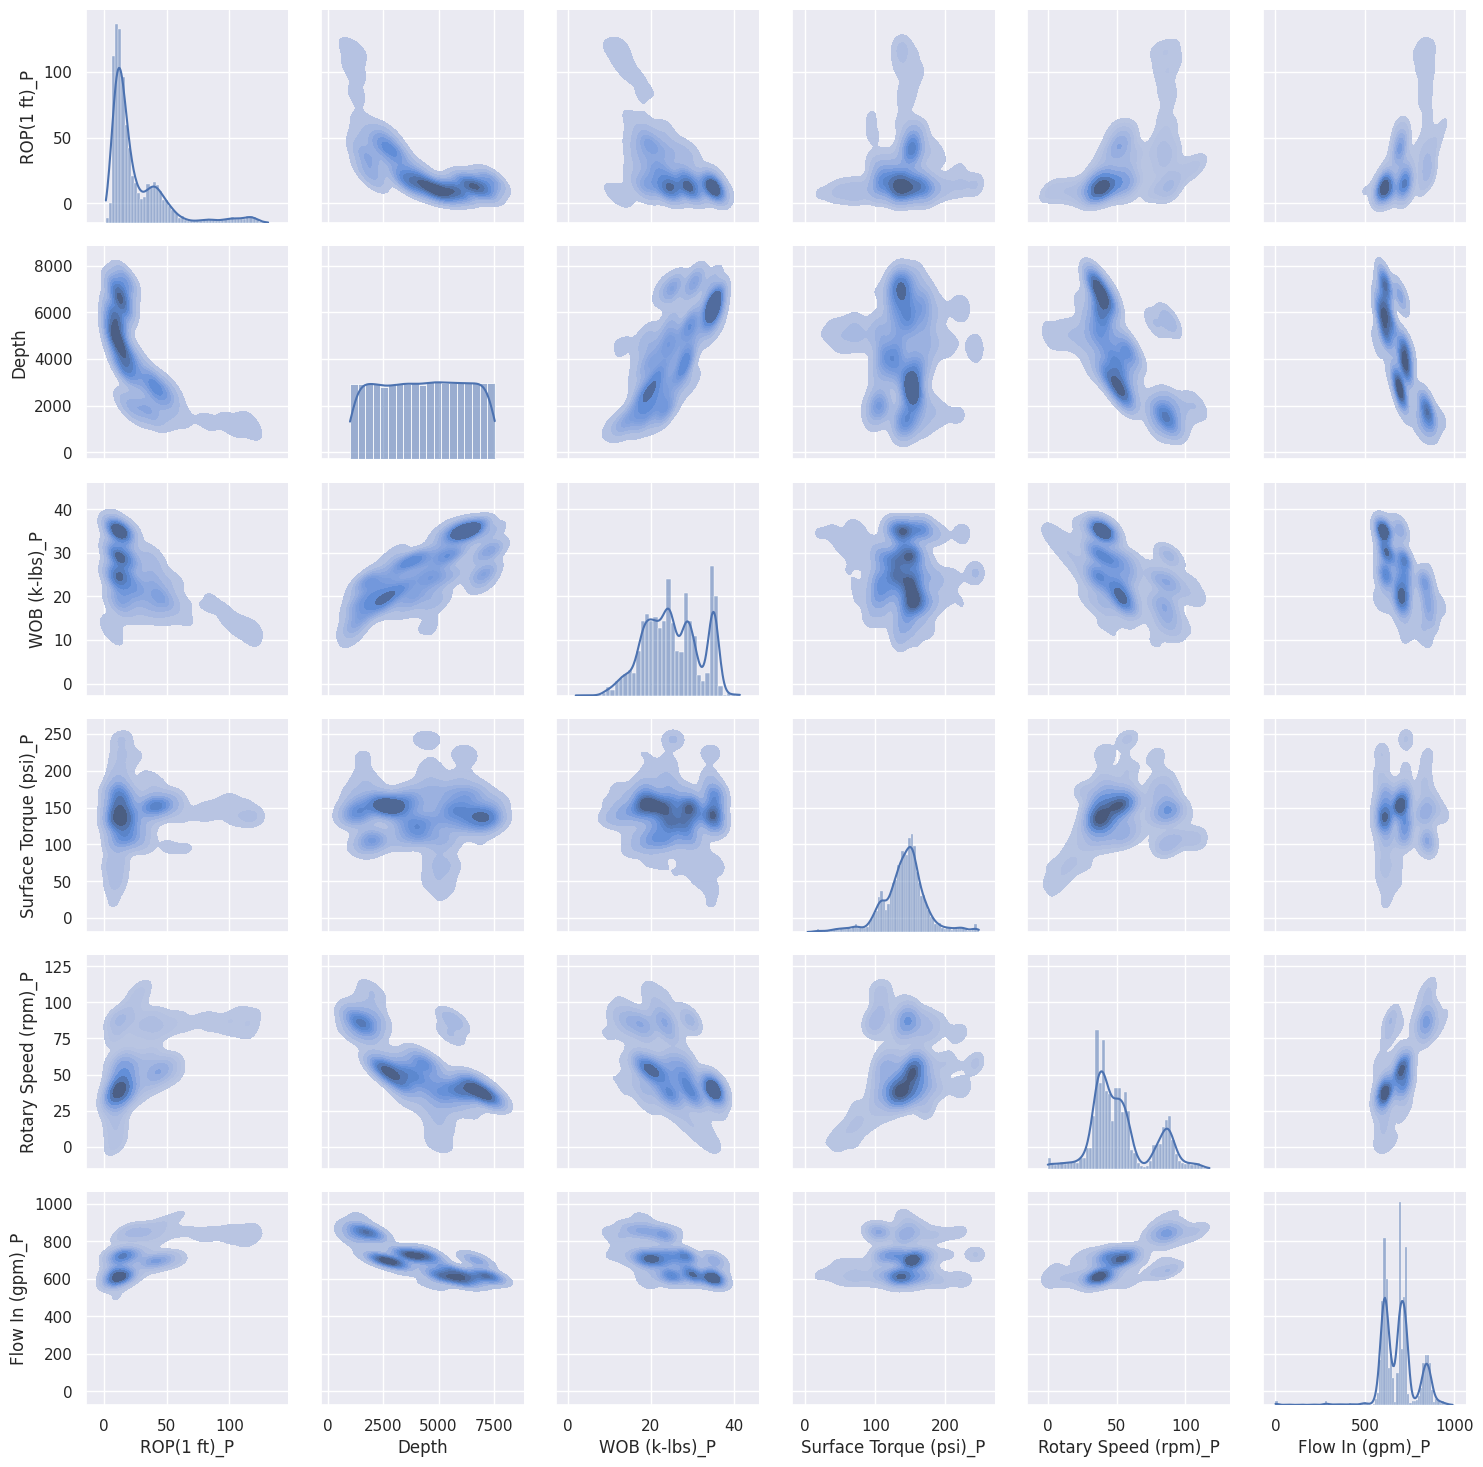

In [10]:
g = sns.PairGrid(geothermal_data_final)
g.map_upper(sns.kdeplot, fill=True)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

**Score Metric**

Since RMSE is essentially standard deviation plus the random and systemic errors of our data and model, it is a good goal to achieve an **RMSE far below our ROP standard deviation (23.36 feet/hour).**

In [11]:
geothermal_data_final.describe()

,ROP(1 ft)_P,Depth,WOB (k-lbs)_P,Surface Torque (psi)_P,Rotary Speed (rpm)_P,Flow In (gpm)_P
count,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000
mean,25.676784,4286.636806,25.244673,140.953645,52.634664,688.689433
std,23.356193,1884.027961,6.709881,32.455780,21.543023,103.875055
min,1.469000,1009.330000,1.942000,3.580000,0.000000,0.000000
25%,11.097500,2661.010000,20.178500,125.549500,38.246500,615.968500
50%,16.165000,4307.100000,24.639000,143.379000,48.061000,693.406000
75%,34.581500,5914.045000,30.098000,156.876500,59.665000,728.461000
max,130.873000,7536.250000,41.443000,247.623000,117.444000,990.626000


## Model Building - Building our Digital Twin — daal4py and XGBoost Optimized Training and Inference

In [12]:
i_flag = 1
model_file = 'test0.pkl'

drilling_data = geothermal_data_final
input_cols = ['WOB (k-lbs)_P', 'Surface Torque (psi)_P', 'Rotary Speed (rpm)_P','Flow In (gpm)_P']
output_col = 'ROP(1 ft)_P'

#### 1. Linear Regression RMSE Score benchmark

We will start by training a linear regression model and evaluating it to establish an RMSE reference point and ensure that our XGBoost model will outperform a simple linear regressor.

In [13]:
x_train, x_test, y_train, y_test = prepare_data(
    drilling_data, input_cols_list=input_cols, output_var=output_col)

print("===== Running Benchmarks for Linear Regression =====")
train_time, pred_time, MSE = linreg(
    x_train, x_test, y_train, y_test, i_flag)
print("Training time = ", train_time)
print("Prediction time = ", pred_time)
print('MSE:', str(round(np.mean(MSE), 3)))
print('Root MSE:', str(np.sqrt(round(np.mean(MSE), 3))))

===== Running Benchmarks for Linear Regression =====


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
INFO:sklearnex: sklearn.linear_model.LinearRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LinearRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LinearRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LinearRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LinearRegression.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LinearRegression.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LinearRe

Training time =  0.002815723419189453
Prediction time =  0.0019898414611816406
MSE: 338.375
Root MSE: 18.394972139147153


We achieve an RMSE of 18.39 feet/hour. This is just 4.97 feet/hour less than the standard deviation of our training data ROP

#### 2. XGBoost Daal4Py Model 

Using XGBoost and automated hyperparameter optimization through GridSearchCV and xgb methods (Figure 12). The XGB_prediction_daal4py custom function from the digital-twin AI Reference Kit is utilized to convert the XGBoost model to daal4py.

In [14]:
x_train, x_test, y_train, y_test = prepare_data(
    drilling_data, input_cols_list=input_cols, output_var=output_col, shuffle=False)
loop_ctr = 5
parameters = {'nthread': [1],
              'learning_rate': [0.02],  # so called `eta` value
              'max_depth': [3, 5],
              'min_child_weight': [6, 7],
              'n_estimators': [750, 1000],
              'tree_method': ['hist']}
print(
    "===== Running Benchmarks for XGB Hyperparameter Training =====")
train_time, trained_model, model_params = XGBHyper_train(
    x_train, y_train, parameters)
print("Training time = ", train_time)
if i_flag:
    prediction, pred_time, MSE = XGB_predict(
        x_test, y_test, trained_model, loop_ctr, i_flag)
    prediction, pred_time_daal4py, MSE_daal4py = XGB_predict_daal4py(
        x_test, y_test, trained_model, loop_ctr, i_flag)
    print("Prediction time = ", pred_time)
    print("daal4py Prediction time = ", pred_time_daal4py)
    print('Root MSE: ', str(np.sqrt(round(np.mean(MSE), 3))))
    print('daal4py Root MSE: ',
                str(np.sqrt(round(np.mean(MSE_daal4py), 3))))
else:
    prediction, pred_time, MSE = XGB_predict(
        x_test, y_test, trained_model, loop_ctr, i_flag)
    print("Prediction time = ", pred_time)
    print('Root MSE: ', str(np.sqrt(round(np.mean(MSE), 3))))

joblib.dump(trained_model, "model_xgbhpo.pkl")

===== Running Benchmarks for XGB Hyperparameter Training =====
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Training time =  11.60622501373291
Prediction time =  0.03125166893005371
daal4py Prediction time =  0.010338783264160156
Root MSE:  6.405388356688453
daal4py Root MSE:  6.405388356688453


['model_xgbhpo.pkl']

With the hyperparameter-optimized XGBoost, we achieved an RMSE of 6.46 feet/hour, which is 16.9 feet/hour lower than the standard deviation of our ROP. 

## Explainable AI (XAI) and SHAP

### Introduction to Explainable AI (XAI)
Explainable AI (XAI) refers to methods and techniques that make the behavior and predictions of machine learning models understandable to humans. The goal of XAI is to provide transparency, interpretability, and trust in AI systems by explaining how models make decisions. This is crucial for ensuring accountability, fairness, and compliance with regulations, especially in critical applications like healthcare, finance, and autonomous systems.

### SHAP (SHapley Additive exPlanations)
SHAP is a popular XAI method that uses cooperative game theory to explain the output of machine learning models. The core idea is to allocate credit for a model’s prediction among its input features by considering the impact of each feature when it is present, missing, or combined with other features. SHAP values provide a unified measure of feature importance, making it easier to understand and compare the contributions of different features.

#### Key Concepts:
- **Shapley Values**: Originating from cooperative game theory, Shapley values fairly distribute the "payout" (model prediction) among the "players" (input features) based on their contributions.
- **Feature Impact**: SHAP values indicate how much each feature contributes to the difference between the actual prediction and the average prediction.

### Waterfall Plot
The SHAP waterfall plot is a visualization that shows how each feature contributes to moving the model output from the base value (average model output) to the final prediction. It provides a detailed breakdown of the impact of each feature on a single prediction.

#### How to Interpret:
- **Base Value**: The average model output over the training dataset.
- **Feature Contributions**: Features that push the prediction higher are shown in red, while those that push it lower are shown in blue.
- **Final Prediction**: The sum of the base value and all feature contributions.

### SHAP Heatmap
The SHAP heatmap provides a high-level overview of the impact of all features across multiple predictions. Unlike the waterfall plot, which focuses on individual predictions, the heatmap shows the collective influence of features on the model’s outputs.

#### How to Interpret:
- **Color Intensity**: Indicates the magnitude of the SHAP values, with brighter colors representing higher impact.
- **Feature Importance**: Helps identify which features consistently have a strong influence on the model’s predictions.
- **Patterns and Clusters**: Reveals patterns and clusters in the data, indicating how different features interact and affect the model’s behavior.

In [15]:
shap.initjs()

In [16]:
explainer = shap.TreeExplainer(trained_model)
shap_values = explainer(x_test)

In [17]:
shap_values[1]

.values =
array([-3.1329765, -0.7708064,  0.4251115, -5.1264462], dtype=float32)

.base_values =
25.36193

.data =
array([ 35.632, 132.62 ,  43.708, 619.602])

When ROP = 16.757 feet/hour, this is the impact of each feature:
- Flow In (GPM) brings the model down from the base value by -5.13 ROP units.
- WOB (k-lbs) brings the model down from the base value by -3.13 ROP units.
- Surface Torque (psi) brings the model down from the base value by -0.77 ROP units.
- Rotary Speed (rpm) brings the model up from the base value by +0.43 ROP units.

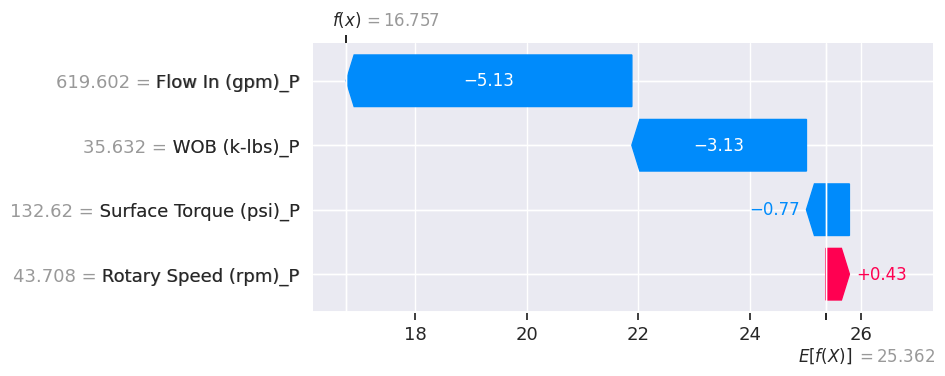

In [18]:
shap.plots.waterfall(shap_values[1])

In [19]:
shap_values[10]

.values =
array([ 2.984469,  4.150899,  2.569414, 11.593514], dtype=float32)

.base_values =
25.36193

.data =
array([ 19.976, 153.367,  49.466, 690.151])

When ROP = 46.66 feet/hour, this is the impact of each feature:
- Flow In (GPM) brings the model up from the base value by +11.59 ROP units.
- WOB (k-lbs) brings the model up from the base value by +2.98 ROP units
- Surface Torque (psi) brings the model up from the base value by +4.15 ROP units.
- Rotary Speed (rpm) brings the model up from the base value by +2.57 ROP units

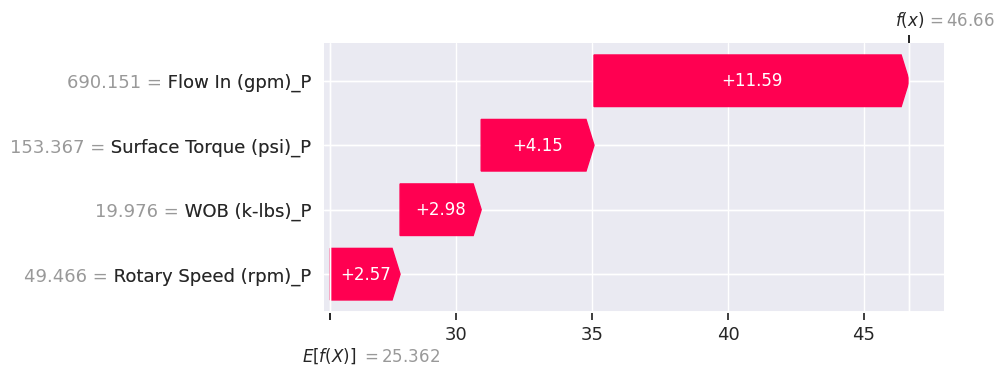

In [20]:
shap.plots.waterfall(shap_values[10])

The SHAP Heatmap serves a similar purpose as the waterfall plot. However, instead of looking at the impact sample by sample, it shows the high-level impact of all features across our model’s outputs. Again, this visualization can help us understand how different features impact our model. In the case of the sharp increase in ROP around instance (sample) 1750, we see very high SHAP values for both Flow In and WOB, indicating that these two features are primarily responsible for the resulting increase in ROP.

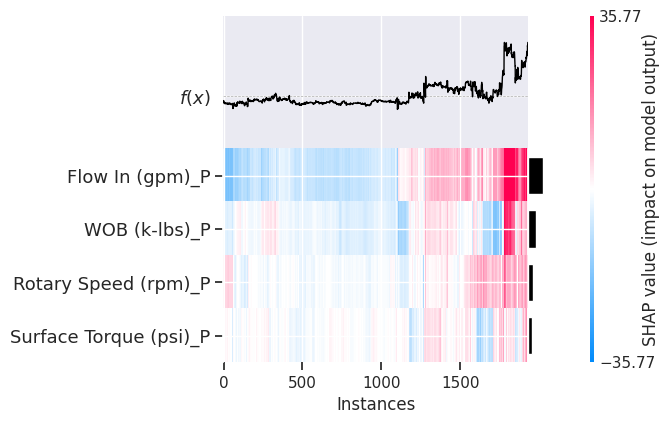

In [21]:
shap.plots.heatmap(shap_values[0:])

- **Feature Impact Varies with ROP:** The influence of features like Flow In, WOB, Surface Torque, and Rotary Speed changes with different ROP levels. At lower ROP, these features tend to have a negative or smaller positive impact, while at higher ROP, their impact becomes more positive and significant.

- **Optimizing Drilling Parameters:** By understanding these impacts, drilling operations can be optimized. For example, adjusting Flow In and WOB based on the current ROP can lead to more efficient drilling.

- **Data-Driven Decisions:** These insights enable data-driven adjustments to drilling parameters, improving overall efficiency and effectiveness.

## Conclusion 

In this project, we leveraged Intel-optimized XGBoost and daal4py libraries to develop a machine learning digital twin for simulating Rate of Penetration (ROP) in drilling operations. This digital twin, represented by our predictive model, provides valuable insights by simulating ROP based on various input features. To enhance trust and interpretability, we integrated an Explainable AI (XAI) workflow using SHAP. This allowed us to clearly understand the impact of each input feature on the model’s predictions, ensuring transparency and confidence in our digital twin’s outputs. Through this approach, we demonstrated the effectiveness of combining advanced machine learning techniques with XAI to optimize and understand complex drilling processes.